# ECSE 415 - Intro. To Computer Vision
## Tutorial: Segmentation and Stereo

In [1]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import mixture

### Gaussian Mixture Model

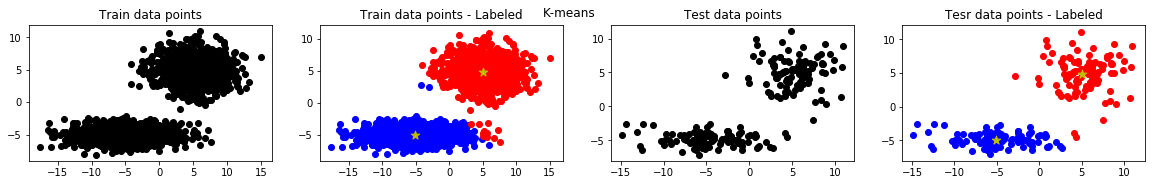

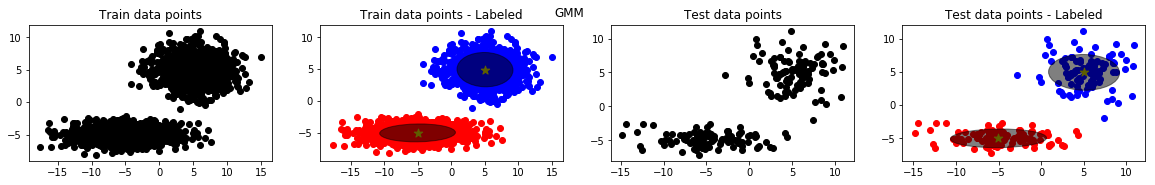

In [2]:
# Train data
traind = np.float32(
       np.vstack((
       np.random.normal(loc=np.array([5,5]), scale=np.array([3,2]), size=(1000,2)),
       np.random.normal(loc=np.array([-5,-5]), scale=np.array([4,1]), size=(1000,2)))))

# Test data
testd = np.float32(
       np.vstack((
       np.random.normal(loc=np.array([5,5]), scale=np.array([3,2]), size=(100,2)),
       np.random.normal(loc=np.array([-5,-5]), scale=np.array([4,1]), size=(100,2)))))

#---------------------------------- K-means --------------------------------------------

# refer tutorial 6

# Training
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)
compactness, labels, centers = cv2.kmeans(traind, 2, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)

A = traind[labels.ravel()==0]
B = traind[labels.ravel()==1]

plt.figure(figsize=(20,2.5))
plt.subplot(141)
plt.plot(traind[:,0], traind[:,1],"ko")
plt.title("Train data points")
plt.subplot(142)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
plt.title("Train data points - Labeled")


# Test
# Find the eclidean distance between the test datapoint and the two cluster centers.
# Test datapoint belongs to the cluster whoes mean is closer to the test datapoint.

labels = np.argmin(np.sum((testd[None,:,:] - centers[:,None,:])**2, -1),0)
A = testd[labels==0]
B = testd[labels==1]

# plt.figure(figsize=(20,2.5))
plt.subplot(143)
plt.plot(testd[:,0], testd[:,1],"ko")
plt.title("Test data points")
plt.subplot(144)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
plt.title("Tesr data points - Labeled")
plt.suptitle("K-means")
plt.show()

#---------------------------------- GMM --------------------------------------------

# A helper function to draw variance
def make_ellipses(gmm, ax):
    K = gmm.means_.shape[0]
    for n in range(K):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color='black')
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        
# sklearn.mixture.GaussianMixture(n_components=1,
#                                 covariance_type=’full’,   #{‘full’ (default), ‘tied’, ‘diag’, ‘spherical’}
#                                 tol=0.001,
#                                 reg_covar=1e-06,
#                                 max_iter=100,
#                                 n_init=1,
#                                 init_params=’kmeans’,     #{‘kmeans’, ‘random’}
#                                 weights_init=None,
#                                 means_init=None,
#                                 precisions_init=None,
#                                 random_state=None,
#                                 warm_start=False,
#                                 verbose=0,                
#                                 verbose_interval=10)

# define a GMM class
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')

# fit GMM on train data
clf.fit(traind)

# the centers of the fitted GMM
centers = clf.means_

# predict cluster membership from the fitted GMM 
label = clf.predict(traind)

A = traind[label==0]
B = traind[label==1]

plt.figure(figsize=(20,2.5))
plt.subplot(141)
plt.plot(traind[:,0], traind[:,1],"ko")
plt.title("Train data points")
h = plt.subplot(142)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
make_ellipses(clf, h)
plt.title("Train data points - Labeled")

# predict cluster membership from the fitted GMM 
label = clf.predict(testd)

A = testd[label==0]
B = testd[label==1]

plt.subplot(143)
plt.plot(testd[:,0], testd[:,1],"ko")
plt.title("Test data points")
h = plt.subplot(144)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
make_ellipses(clf, h)
plt.title("Test data points - Labeled")

plt.suptitle("GMM")
plt.show()

# print(np.unique(label))

### Disparity map from stereo images

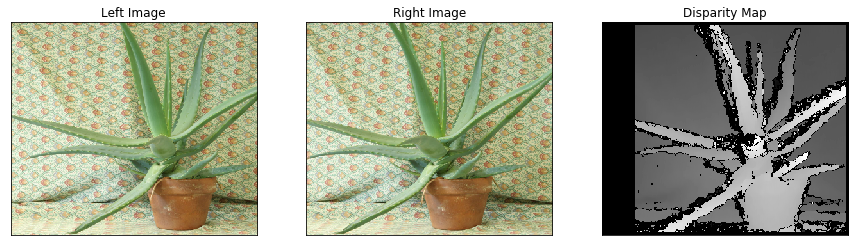

In [3]:
# load left and right images
imgL = cv2.imread("aloeL.jpg");
imgR = cv2.imread("aloeR.jpg");

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# convert to grayscale
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# compute disparity map
# numDisparities is multiple of 16
# blocksize is always odd value

stereo = cv2.StereoBM_create(numDisparities=16*3, blockSize=9) #stereo correspondence using the block matching algorithm
disparity = stereo.compute(imgL_gray, imgR_gray)

# display images
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(disparity, cmap="gray")
plt.title("Disparity Map"), plt.xticks([]), plt.yticks([])
plt.show()

### Epipolar Geometry

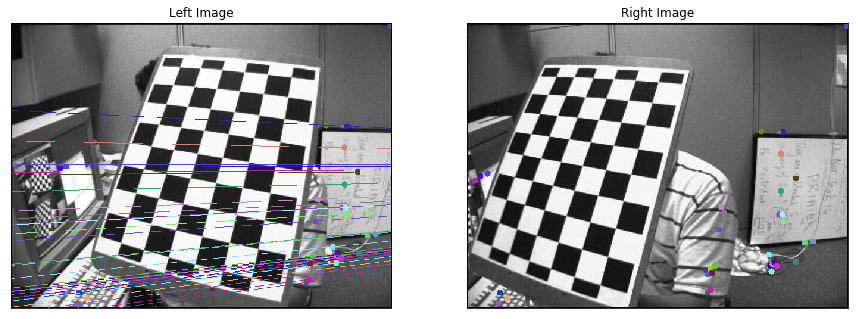

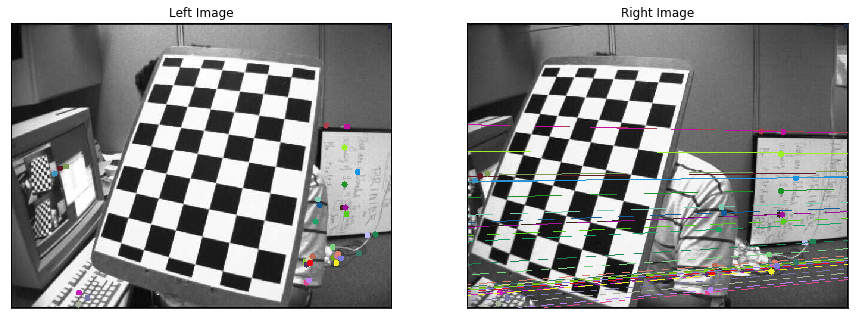

In [4]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# load left and right images
imgL = cv2.imread("left08.jpg", cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread("right08.jpg", cv2.IMREAD_GRAYSCALE)

# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# Now, we want to match keypoints and remove matches on repeatative structure.
# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2) # query image, train image

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.5 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS) 
# epipolar line in Right image = F ptsL (matrix multiplication)
# epipolar line in Left image = F' ptsL (matrix multiplication)


# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()